<a href="https://colab.research.google.com/github/luizgontijo/DataScience_Projects/blob/master/SVM_analysis_using_digt_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM Analysis Using Digit Recognition

**Author: Luiz Fernando da Costa Gontijo -- lz.gontijo@gmail.br**

The goal of this notebook is to correctly identify digits from a dataset of tens of thousands of handwritten images and compare the results of using different hyperparameters on the SVM model. In order to study Support Vector Machines (SVM) models, this notebook uses such techniques for image classification. By the final of this notebook, we use other methods to compare with the best SVM model raised. 

This notebook is divide into sections:
* Data analysis;
* Using SVM to digit classification;
* Using the best SVM model;
* Using Logistic Regression and Random Forest;
* Conclusions


# Data Analysis

The first thing we need to do before aplying any machine learning model is to study and analyze the data we will use. This section has the propose to analyse the different classes and the frequency of occurrences.

In [1]:
# imports for this section
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

In [2]:
# define a seed to replication
np.random.seed(202)
sns.set()

### Reading the dataset

**Pen-Based Recognition of Handwritten Digits Data Set** is a simple image bank and well known in image recognition. It consists of 8-by-8-pixel gray-scale images divided into 10 classes of digits.

A complete description can be found at the following link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [12]:
x, y = datasets.load_digits(return_X_y=True)

def split_data(x = x, y = y):
  # divide data into test and train
  x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                      test_size=.3,
                                                      random_state=183212)
  return x_train, x_test, y_train, y_test

print('train samples: %i' % x_train.shape[0],
      'test samples: %i' % x_test.shape[0],
      'features: %i' % x_train.shape[1],
      'lebels: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

train samples: 1257
test samples: 540
features: 64
lebels: 10



The first thing we have to do in any data exploration is to vizualise the data we are dealing with. 

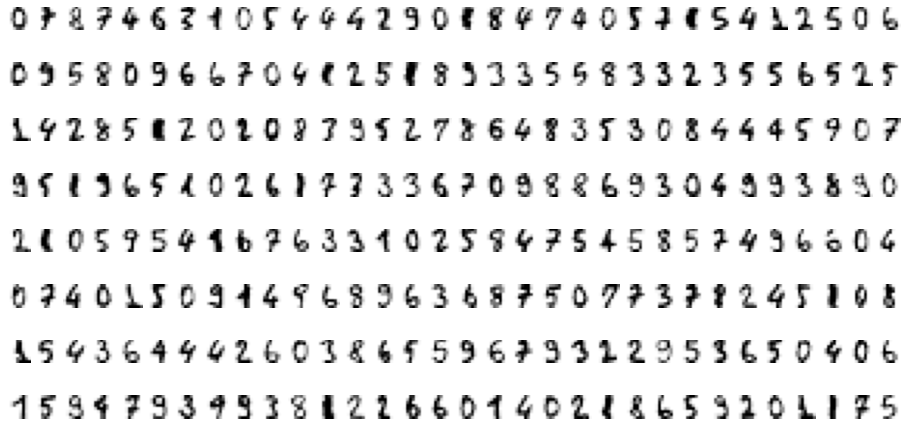

In [19]:
# show the first 64 digit images
plt.figure(figsize=(16, 8))

for ix in range(8 * 32):
  plt.subplot(8, 32, ix + 1)
  plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
  plt.axis('off')


## Visualize the difference between labels

For this dataset, one good way to analyse the data is to visualize the approximation of each label of digits. For this proposal we use TSNE (t-Distributed Stochastic Neighbor Embedding), a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


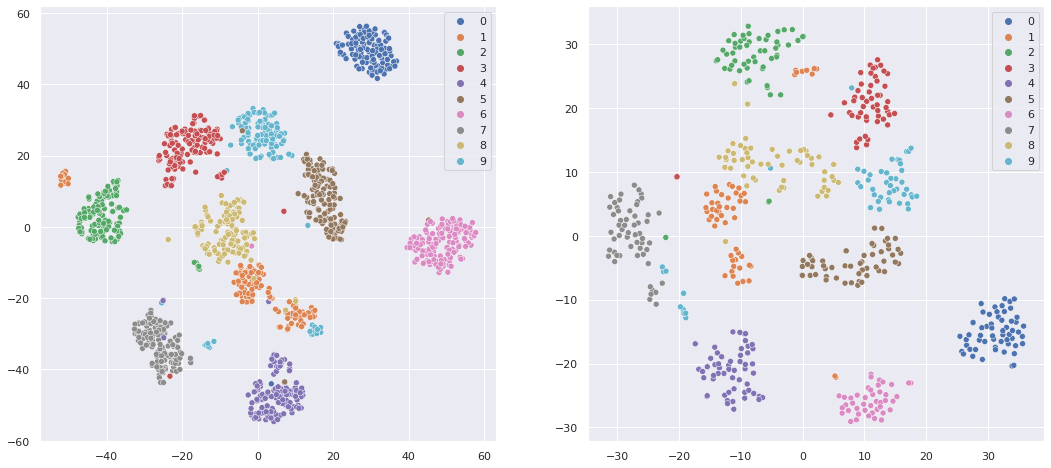

In [5]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(18, 8))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

By the images above, we see a good sepparation between some classes, as 6, 4 and 0. But for labels 9, 3 and 8, for example, there is some overlap. This can be explained by the shape of these numbers: they can be very similar from the way someone writes it.


## Visualize the different frequencies between labels

Now we show the frequency of examples in each label. This analysis is important to show if there is any unbalanced label. Unbalanced labels can make the training of the classification models difficult.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


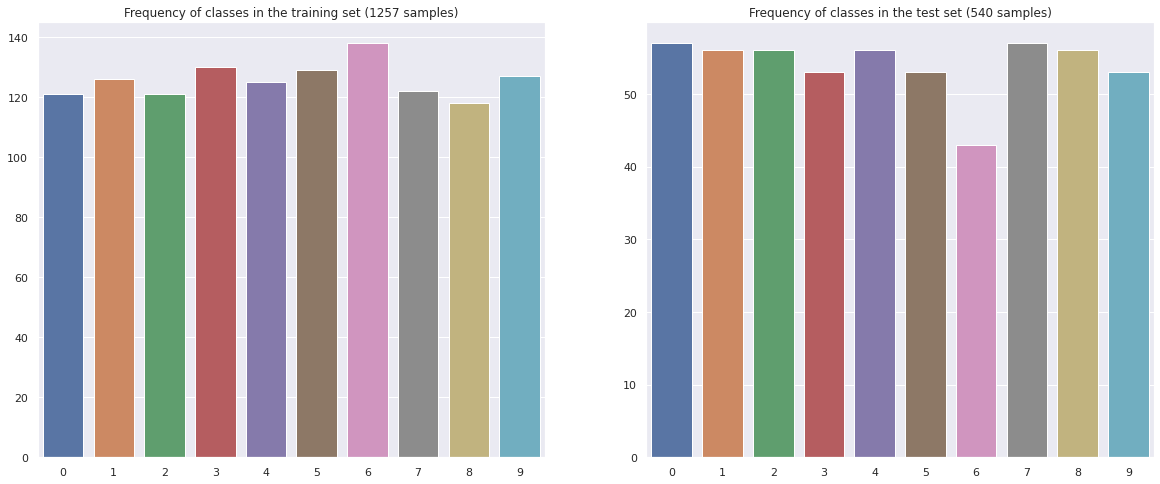

In [6]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.title('Frequency of classes in the training set (%i samples)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequency of classes in the test set (%i samples)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

As shown by the images above, there is some classes with less examples, as 4 and 5 for the training set and 9 and 8 for the test set. But, this differences are not relevant, as we can conclude by comparing with the others labels. 

# Using SVM to digit classification

For a complete analysis of the SVM model of machine learning, this section provides results for the usage of diferent kernel types present in the scikit-learn library.

The kernels we use in this section are: linear, polynomial, RBF and sigmoid. All those kernel types has diferent hyperparameters that can be configurated to provide better results. 

The combination of each parameter is made using the Grid Search technique. For simplification the results are obtained using cross-validation parameter of search equal to 5.

Como a Atividade foi realizada:

Foram testados quatro kernels diferentes: linear, polinomia, RBF e sigmoid.

Para cada Kernerl foram avaliadas as implicações de diferentes valores para seus hiperparâmetros. Para cada avaliação, foi escolhido o melhor hiperparâmetro. Nesta etapa foram avaliados os exemplos de treinamento e validação somente.

Ao final da análise de cada Kernel, realizada a Grid Search com cv igual a 5 para ser obtida a melhor combinação esntre os hiperparâmetros considerados. O valor cv igual a 5 foi escolhido por simplicidade, acredita-se que, com a quantidade disponível de dados, não há necessidade de um valor mais elevado deste atributo da busca. Nesta etapa foram avaliados os exemplos de treinamento e validação somente.

Após a busca da melhor configuração de cada Kernel, foi realizada a busca da melhor configuração de parâmetros dentre todos os Kernels. Nesta etapa foram avaliados os exemplos de treinamento e validação somente.

Por fim, a melhor configuração foi aplicada ao conjunto de dados de validação e teste para a obtenção dos valores finais de acurácia.

## Define train and validation datasets

Using the train dataset obtained in the previous section, we obtain a new dataset to test the models; the validation dataset. 


In [20]:
# obtain the validation and train datasets
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train,
                                                    test_size=.2,
                                                    random_state=183212)
print('train samples: %i' % x_train.shape[0],
      'validation samples: %i' % x_val.shape[0],
      'features: %i' % x_train.shape[1],
      'labels: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

train samples: 1257
validation samples: 252
features: 64
labels: 10



## Data preprocessing

Standardize features by removing the mean and scaling to unit variance. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
X_train = scaler.fit_transform(X_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

**Treinar modeos SVM para diferentes Kernels e parâmetros**

Estudar os parâmetros separadamente. Depois apllicar o Grid Search para encontrar os melhores parâmetros.

Registrar resultados de Acurácia Balanceada.



In [47]:
# impor librarys for this section
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Classes do analyse parameters

In [23]:
class clf_svm:
  def __init__(self, kernel):
    self.kernel = kernel

  # analyze linear kernel
  def svm_lin(self, penaltyArray):
    trainAcc = []
    valAcc = []
    for penalty in penaltyArray:
      
      clf = svm.SVC(kernel=self.kernel, C=penalty)
      clf.fit(X_train, Y_train)

      trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
      valAcc.append(accuracy_score(y_val, clf.predict(x_val)))
    return trainAcc, valAcc

  # analyze polynomial kernel
  def svm_poly(self, penaltyArray=False, gammaArray=False, degreeArray=False):
    trainAcc = []
    valAcc = []

    if penaltyArray != False:
      for penalty in penaltyArray:  
        clf = svm.SVC(kernel=self.kernel, C=penalty)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))
      
    elif gammaArray != False:
      for gamma in gammaArray:
        clf = svm.SVC(kernel=self.kernel, gamma=gamma)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))

    elif degreeArray != False:
      for degree in degreeArray:
        clf = svm.SVC(kernel=self.kernel, degree=degree)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))
    
    return trainAcc, valAcc

  # analyze rbf kernel
  def svm_rbf(self, penaltyArray=False, gammaArray=False):
    trainAcc = []
    valAcc = []
    if penaltyArray != False:
      for penalty in penaltyArray:  
        clf = svm.SVC(kernel=self.kernel, C=penalty)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))
      
    elif gammaArray != False:
      for gamma in gammaArray:
        clf = svm.SVC(kernel=self.kernel, gamma=gamma)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))

    return trainAcc, valAcc

  # analyze sigmoid kernel
  def svm_sigmoid(self, penaltyArray=False, gammaArray=False, coef0Array=False):
    trainAcc = []
    valAcc = []
    if penaltyArray != False:
      for penalty in penaltyArray:  
        clf = svm.SVC(kernel=self.kernel, C=penalty)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))
      
    elif gammaArray != False:
      for gamma in gammaArray:
        clf = svm.SVC(kernel=self.kernel, gamma=gamma)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))

    elif coef0Array != False:
      for coef0 in coef0Array:
        clf = svm.SVC(kernel=self.kernel, coef0=coef0)
        clf.fit(X_train, Y_train)

        trainAcc.append(accuracy_score(Y_train, clf.predict(X_train)))
        valAcc.append(accuracy_score(y_val, clf.predict(x_val)))

    return trainAcc, valAcc

  def svm_test_data(self, clf):
    pred = clf.predict(x_test) 
    print(classification_report(y_test, pred))
    print('accTest = ', accuracy_score(y_test, pred))


In [49]:
class svm_plot_train_val:
  def __init__(self, trainAcc, valAcc, array, parameterName):
    self.trainAcc = trainAcc
    self.valAcc = valAcc
    self.array = array
    self.parameterName = parameterName

  def plot_acc(self):
    x = np.around(self.array, 2)
    plt.figure(figsize=(13, 6))
    plt.plot(self.array, self.trainAcc, 'r-', label = 'trainAcc')
    plt.plot(self.array, self.valAcc, 'g-', label = 'valAcc')
    plt.legend(loc = 'best')
    plt.title('Acc x %s' %self.parameterName)
    plt.xticks(x)
    plt.xlabel(self.parameterName)
    plt.ylabel('Acc')
    plt.show()

  def cm_clf_svm(self, y_test, x_test, clf):
    plt.figure(figsize=(13, 6))
    disp = plot_confusion_matrix(clf, x_test, y_test,
                                  display_labels=[1,2,3,4,5,6,7,8,9],
                                  cmap=plt.cm.Blues)
    disp.ax_.set_title("Confusion Matrix - Test Data")

  def cm_lr_rf(self, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5,6,7,8,9])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')


In [25]:
class svm_grid_search:
  def __init__(self, parameters):
    self.parameters = parameters

  def svm_search(self):
    grid = GridSearchCV(svm.SVC(), param_grid=self.parameters, cv = 5) 
    grid.fit(x_train, y_train)
    predict_train = grid.predict(x_train)
    predict_val = grid.predict(x_val)
    print(classification_report(y_val, predict_val)) 
    print('Best parameters: ',grid.best_params_) 
    print('Best SVM model: ',grid.best_estimator_) 
    print('accTrain =', round(accuracy_score(y_train, predict_train),3))
    print('accVal =', round(accuracy_score(y_val, predict_val),3)) 
    return grid

  def lr_rf_search(self, clf):
    grid = GridSearchCV(clf, param_grid=self.parameters, cv = 5) 
    grid.fit(x_train, y_train)
    predict_train = grid.predict(x_train)
    predict_val = grid.predict(x_val)
    print(classification_report(y_val, predict_val)) 
    print('Best parameters: ',grid.best_params_) 
    print('Best model: ',grid.best_estimator_) 
    print('accTrain =', round(accuracy_score(y_train, predict_train),3))
    print('accVal =', round(accuracy_score(y_val, predict_val),3)) 
    return grid
      

## Apply the linear kernel

For the linear kernel, we can analyse the penality (C) parameter. 

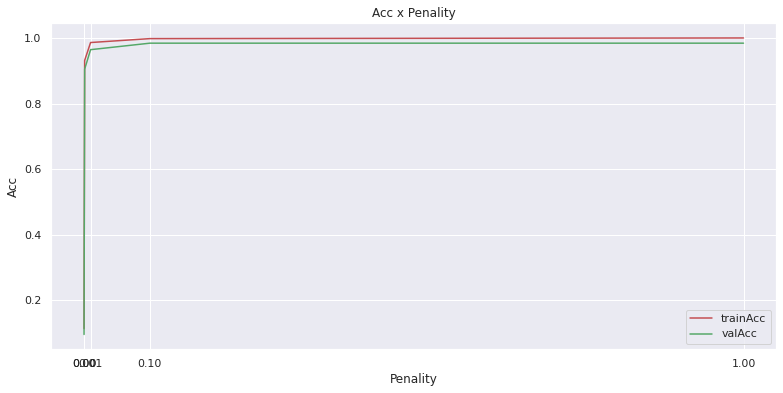

In [13]:
penaltyArray = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

lin_kernel = clf_svm('linear')

trainAcc, valAcc = lin_kernel.svm_lin(penaltyArray=penaltyArray)

plot = svm_plot_train_val(trainAcc, valAcc, penaltyArray, parameterName='Penality')
plot.plot_acc()

The tolerance for classification errors is necessary for non-linearly separable databases, that is, data in which a line as a separation hyperplane would not be enough to separate any data set without errors. Thus, this parameter indicates the acceptance of certain classification errors. However, one must consider the choice of a C value small enough to not tolerate a large amount of errors and, at the same time, large enough to supply the need to adapt the model created to the non-linearity imposed by the data set and not inducing the model to high specialization.

For the Linear Kernel, increasing the C value, which indicates the penalty for classification errors, results in a more rigid margin of choice, that is, there is less tolerance for errors. Lower C values ​​indicate classifiers that tolerate the wrong classification given by the created SVM model to a greater degree.

Thus, for this Kernel the optimal value of C is found when equal to 1.0. From this value there is no further change in the results of validation and training accuracy. In addition, as only parameter C was varied in this analysis, it was not necessary to use Grid Search to find the best parameters. 

Best choices: 

C = 1.0;

accTrain = 1;


accVal = 0.9889.


In [14]:
param_grid_lin = {'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],   
                  'kernel': ['linear']}  
grid_lin = svm_grid_search(param_grid_lin)
grid_lin.svm_search()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Best parameters:  {'C': 1.0, 'kernel': 'linear'}
Best SVM model:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probab

The best configuration, after Grid Search and the application of k-fold with k equal to 5, implies C equal to 1.0; this value was also found by the simple search performed in the step prior to the search by Grid Search.

FInal results for linear kernel:

C = 1.0

accTrain = 1.0

accVal = 1.0


## Apply the polynomial kernel

For the polynomial kernel, we can analyse the degree, gamma and penality (C) parameters

First we see the results for differente values of penality.




[0.1154228855721393, 0.11840796019900497, 0.136318407960199, 0.5432835820895522, 0.9741293532338309, 1.0, 1.0]
[0.09523809523809523, 0.10317460317460317, 0.0873015873015873, 0.5277777777777778, 0.9246031746031746, 0.9682539682539683, 0.9682539682539683]


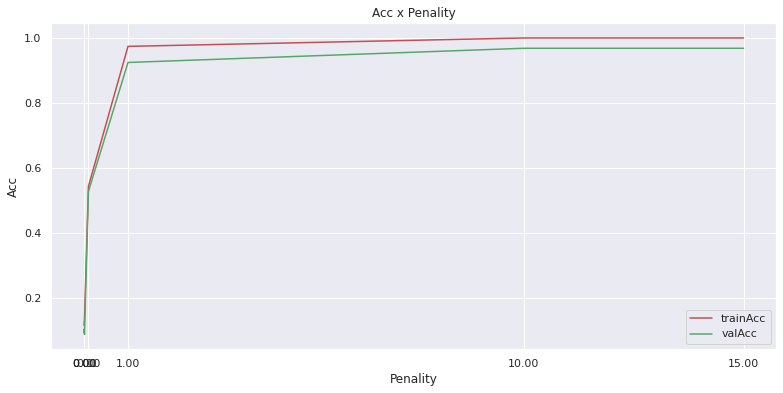

In [15]:
penaltyArray = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 15]

poly_kernel = clf_svm('poly')

trainAcc, valAcc = poly_kernel.svm_poly(penaltyArray=penaltyArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, penaltyArray, parameterName='Penality')
plot.plot_acc()

For the polynomial kernel the increase in C also increases the training accuracy and model validation values. This is given, as explained in the analysis of the Linear Kernel, by the greatest restriction for classification errors. Therefore, with more restrictions, the lower the chances of misclassifying an example. Therefore, the C value must be chosen in order to maximize the accuracy values ​​returned.

Best choices:

C = 10.0

trainAcc = 1.0

valAcc = 0.968

Now we apply different values of degree.




[0.9900497512437811, 0.991044776119403, 0.9741293532338309, 0.8656716417910447, 0.7502487562189055, 0.5701492537313433, 0.4626865671641791, 0.4059701492537313, 0.37910447761194027, 0.3522388059701492]
[0.9761904761904762, 0.9523809523809523, 0.9246031746031746, 0.7857142857142857, 0.6547619047619048, 0.4801587301587302, 0.4126984126984127, 0.3253968253968254, 0.2857142857142857, 0.25793650793650796]


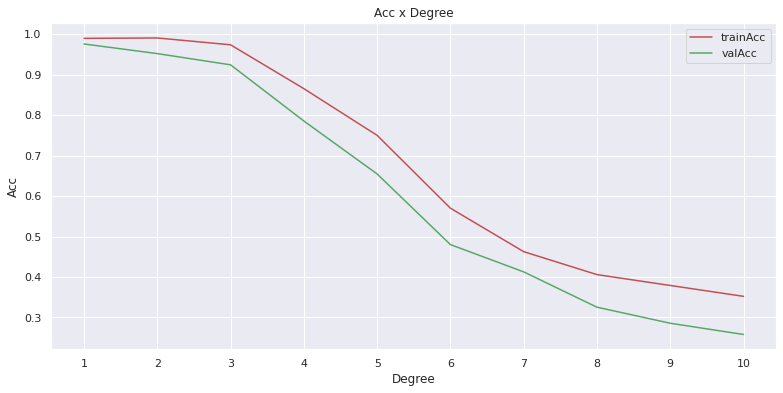

In [16]:
degreeArray = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

poly_kernel = clf_svm('poly')

trainAcc, valAcc = poly_kernel.svm_poly(degreeArray=degreeArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, degreeArray, parameterName='Degree')
plot.plot_acc()


As we see by the image above, the increasse of the degree value of the polynomial kernel implies in a decrease in the performance of the SVM classification model. This is explained by the greater flexibility of the decision boundary for higher degree values ​​of the model. The flexibility discussed in this topic indicates the conformity of the classification hyperplane; the hyperplane for high degree values ​​would be curved enough to misclassify the data set.


Best choice:

degree = 1.0

accTrain = 0.990

accVal = 0.976

Now we apply different values of gamma.


[0.11343283582089553, 0.11641791044776119, 0.8139303482587065, 1.0, 1.0, 1.0]
[0.09523809523809523, 0.09523809523809523, 0.753968253968254, 0.9682539682539683, 0.9682539682539683, 0.9682539682539683]


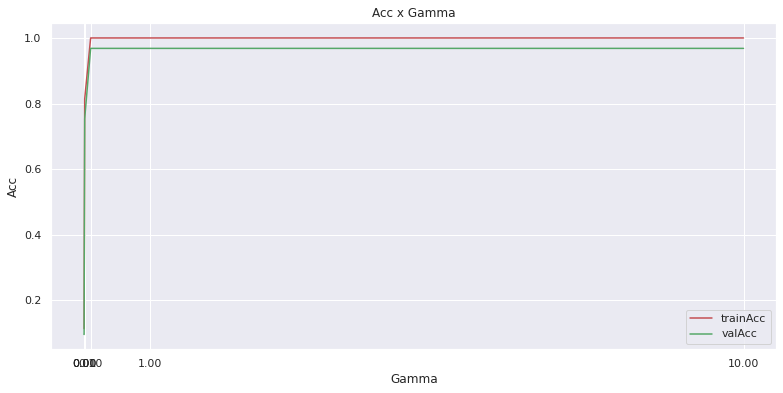

In [17]:
gammaArray= [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

poly_kernel = clf_svm('poly')

trainAcc, valAcc = poly_kernel.svm_poly(gammaArray=gammaArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, gammaArray, parameterName='Gamma')
plot.plot_acc()

The gamma parameter indicates the extent of the influence of a training example. Thus, if the gamma value is too high, the radius of the area of ​​influence of the support vector that defines a class of examples will be very small, being able to define only the corresponding example. Conversely, when gamma is very small, the model becomes very generalized, that is, the area of ​​influence of a certain support vector can include the entire data set; the model could behave as a linear SVM, in which there is no conformity with the nonlinearities employed by the data set.

In general, high gamma values ​​increase the variance of the classifier model, promoting overfitting. Small gamma values ​​imply an increase in the model's bias, indicating, promoting underfitting.

As shown in the graph above, there was no overfitting of the model when using the chosen gamma values. Therefore, one can choose the gamma values ​​corresponding to the best results to ascertain this item.

Best choice:

gamma = 1e-1

accTrain = 1.0

accVal = 0.968




Now we must apply the grid search to find the best parameters for the polynomial kernel.

In [139]:
param_grid_poly = {'C': [ 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],  
              'gamma': [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0], 
              'degree': [1, 2, 3, 4, 5, 6, 7],
              'kernel': ['poly']}  

grid_poly = svm_grid_search(param_grid_poly)
grid_poly.svm_search()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Best parameters:  {'C': 0.1, 'degree': 1, 'gamma': 10.0, 'kernel': 'poly'}
Best SVM model:  SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=10.0, kernel='poly',
  

## Apply the RBF kernel

For the RBF kernel, we can analyse the penality and gamma parameters,

First we see the results for differente values of penality.

[0.11343283582089553, 0.11343283582089553, 0.11343283582089553, 0.9492537313432836, 0.9970149253731343, 1.0, 1.0]
[0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.9087301587301587, 0.9801587301587301, 0.9880952380952381, 0.9880952380952381]


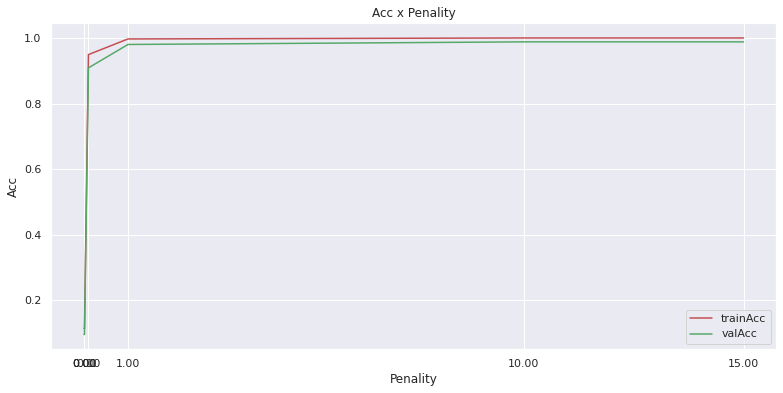

In [19]:
rbf_kernel = clf_svm('rbf')

trainAcc, valAcc = rbf_kernel.svm_poly(penaltyArray=penaltyArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, penaltyArray, parameterName='Penality')
plot.plot_acc()

For the RBF Kernel, the accuracy values ​​also increase according to the increase in the C value. This is given, as explained earlier, by the greater error restriction and increased rigidity of the classification hyperplane.

Best choice:

C = 10

accTrain = 1.0

accVal = 0.988

[0.29850746268656714, 0.9582089552238806, 0.9930348258706467, 1.0, 1.0, 1.0]
[0.23412698412698413, 0.9325396825396826, 0.9761904761904762, 0.9206349206349206, 0.0992063492063492, 0.09523809523809523]


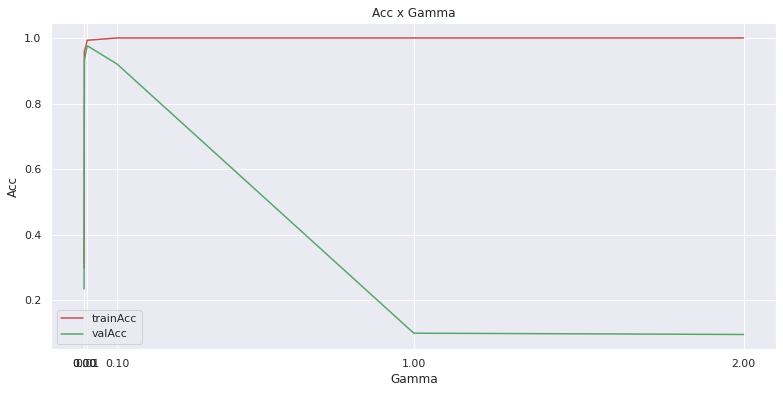

In [23]:
gammaArray= [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2]

rbf_kernel = clf_svm('rbf')

trainAcc, valAcc = rbf_kernel.svm_poly(gammaArray=gammaArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, gammaArray, parameterName='Gamma')
plot.plot_acc()

As shown by the figure above, the increase in gamma implies overfitting of the trained model. This is observed by decreasing the accuracy value for the validation data while there is a high accuracy value for the training data.

Overfitting occurs, as explained earlier, by the characteristic used by the gamma parameter. The higher the gamma value, the smaller the radius of influence of the support vector that defines a class of examples. Therefore, only the training example that defines a support vector could be classified in its correct class. New examples, such as validation data, would be misclassified.

In view of these factors regarding the gamma parameter, one must consider the value for which there is the greatest generalization of the model.

Best choice:

gamma = 1e-2

accTrain = 0.9930

accVal = 0.9760

In [24]:
param_grid_rbf = {'C': [ 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],  
              'gamma': [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0], 
              'kernel': ['rbf']}  

grid_rbf = svm_grid_search(param_grid_rbf)
grid_rbf.svm_search()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Best parameters:  {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Best SVM model:  SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1

## Apply the sigmoid kernel
For the sigmoid kernel, we can analyse the penallity, gamma and coef0 parameters>


First we apply different values of penallity using the sigmoid kernel.

In [27]:
sigmoid_kernel = clf_svm('sigmoid')

[0.11343283582089553, 0.11343283582089553, 0.19402985074626866, 0.9243781094527364, 0.9681592039800995, 0.954228855721393, 0.9532338308457712]
[0.09523809523809523, 0.09523809523809523, 0.14682539682539683, 0.9087301587301587, 0.9325396825396826, 0.9087301587301587, 0.9126984126984127]


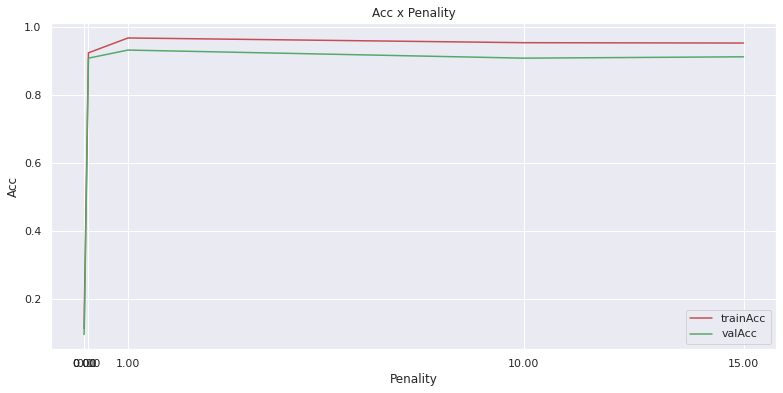

In [28]:
trainAcc, valAcc = sigmoid_kernel.svm_sigmoid(penaltyArray=penaltyArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, penaltyArray, parameterName='Penality')
plot.plot_acc()

For the sigmoid kernel, overfitting was observed for very large C values. This is observed by the decrease in accuracy for validation data at the same time as the increase in accuracy for training data occurred; this indicates a low generalization for the classification of new examples.

Best choice:

C = 1.0

accTrain = 0.968

accVal = 0.9327

[0.11343283582089553, 0.9313432835820895, 0.9800995024875622, 0.6159203980099502, 0.37910447761194027, 0.3870646766169154]
[0.09523809523809523, 0.9047619047619048, 0.9563492063492064, 0.6468253968253969, 0.4007936507936508, 0.3611111111111111]


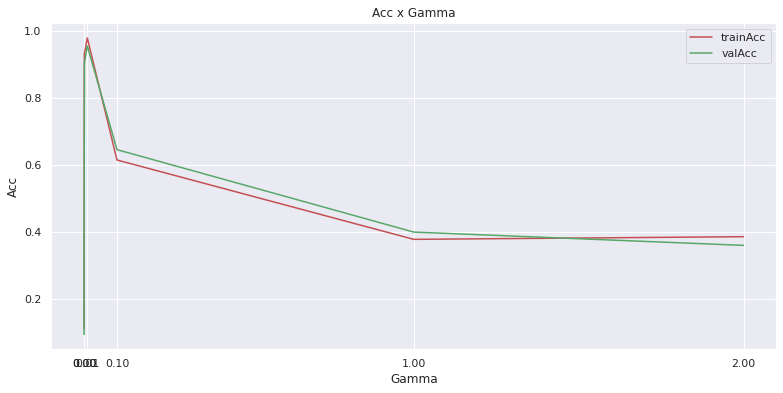

In [29]:
gammaArray= [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2]

trainAcc, valAcc = sigmoid_kernel.svm_sigmoid(gammaArray=gammaArray)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, gammaArray, parameterName='Gamma')
plot.plot_acc()

The gamma parameter for the sigmoid kernel indicated a certain overfitting of the model when considering high values; this is observed by the decrease in the accuracy value for the validation data in relation to the accuracy of the training data.

The gamma parameter, as observed in the graph above, indicates a good generalization of the model to a certain value, however, its change starts to decrease the accuracy values, both for training data and for validation data.

Best choice:

gamma = 1e-3

accTrain = 0.931

accVal = 0.904

[0.9681592039800995, 0.9681592039800995, 0.9671641791044776, 0.9651741293532339, 0.9582089552238806, 0.9034825870646767, 0.8676616915422886, 0.16218905472636816, 0.11343283582089553, 0.11343283582089553]
[0.9325396825396826, 0.9325396825396826, 0.9325396825396826, 0.9325396825396826, 0.9206349206349206, 0.8928571428571429, 0.8611111111111112, 0.12698412698412698, 0.09523809523809523, 0.09523809523809523]


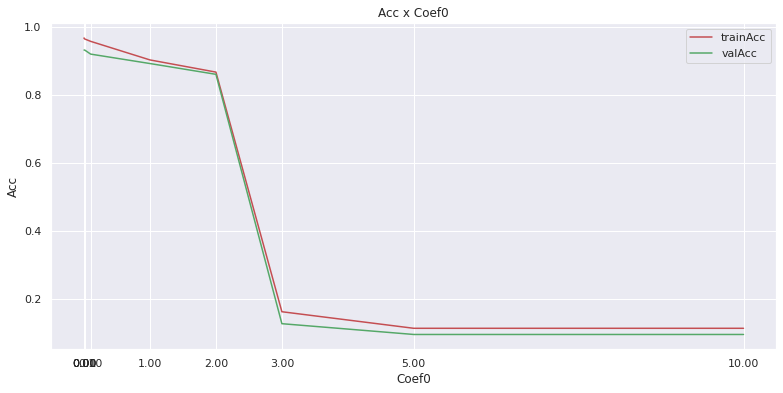

In [35]:
coef0Array= [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2, 3, 5, 10.0]

trainAcc, valAcc = sigmoid_kernel.svm_sigmoid(coef0Array=coef0Array)

print(trainAcc)
print(valAcc)

plot = svm_plot_train_val(trainAcc, valAcc, coef0Array, parameterName='Coef0')
plot.plot_acc()

The increase in the coef0 parameter indicates a decrease in accuracy for both training data and validation data.

Best choice

coef0 = 1e-4

accTrain = 0.968

accVal = 0.932

In [37]:
param_grid_sigmoid = {'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],  
              'gamma': [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0], 
              'coef0': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],
              'kernel': ['sigmoid']}  

grid_sigmoid = svm_grid_search(param_grid_sigmoid)
grid_sigmoid.svm_search()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      0.94      0.97        18
           4       1.00      0.91      0.96        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       0.97      1.00      0.98        30
           8       0.84      1.00      0.91        16
           9       0.97      0.97      0.97        34

    accuracy                           0.98       252
   macro avg       0.98      0.98      0.98       252
weighted avg       0.98      0.98      0.98       252

Best parameters:  {'C': 10.0, 'coef0': 1e-05, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best SVM model:  SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=1e-05,
    decision_function_shape='ovr', degree=3, gamma=0.001, kerne

Finally, this step implies obtaining the best model for all possible combinations between the types of kernel studied.

For this, Grid Search will also be used; however, this time the test model kernel will also be varied.


In [50]:
param_grid_general = {'C': [ 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],  
              'gamma': [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0], 
              'coef0': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],
              'degree': [1, 2, 3, 4, 5],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

grid_general = svm_grid_search(param_grid_general)
grid = grid_general.svm_search()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Best parameters:  {'C': 0.001, 'coef0': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
Best SVM model:  SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=10.0,
    decision_function_shape='ovr', degree=2, gamma=1.0,

In [51]:
grid

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                               10.0],
                         'coef0': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'degree': [1, 2, 3, 4, 5],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## Conclusions about the different kernels study present above

In this activity, the implications of changes in the parameters C, degree, gamma and coef0 were observed for the Linear, Polynomial, RBF and Sigmoid Kernels for the SVM classification algorithm. Thus, it was possible to analyze the accuracy results for the training and validation data.

Through the Grid Serch, the best possible configuration was obtained using the parameters listed and each Kernel available. For this search, k-fold with k equal to 5 was used to update the parameters.

It is noted that, even with the use of k-fold, 20% of the initial training data was separated for the separate validation of the Grid Search. Thus, as observed in the Table above, the accuracy results with the use of validation data (data separated initially and not used in Grid Search) for the linear model with only the variation for parameter C was better than the result obtained after the general Grid Search, which tested all parameters in all Kernels.


# Using the test data on the best SVM model obtained

In this part of the notebook we use the test data to evaluete de model obtained using the grid search on the last step of the section above. 

In [52]:
clf_test = clf_svm(kernel = None)

clf_test.svm_test_data(grid)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       0.98      1.00      0.99        56
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00        53
           4       1.00      1.00      1.00        56
           5       1.00      0.98      0.99        53
           6       1.00      1.00      1.00        43
           7       0.98      0.96      0.97        57
           8       0.96      0.96      0.96        56
           9       0.93      0.94      0.93        53

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

accTest =  0.9851851851851852


<Figure size 936x432 with 0 Axes>

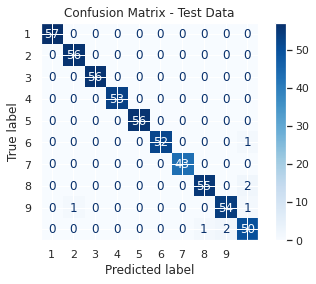

In [62]:
cm = svm_plot_train_val(trainAcc=None, valAcc=None, array=None, parameterName = None)

cm.cm_clf_svm(x_test = x_test, y_test=y_test, clf = grid)

# Using Logistic Regression and Random Forest to compare with the SVM classifier

In this section we use other two classifiers, Logist Regression and Random Forest to compare th results with the SVM classifier. 


To simplify comparisons, a grid search was applied for the classification models used to find the best parameters of the Logistic Regression and Random Forest classifiers. 


## Logistic Regression



In [60]:
param_grid_lr = {'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]}

grid_lr = svm_grid_search(parameters = param_grid_lr)
lr_model = grid_lr.lr_rf_search(clf = LogisticRegression())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Best parameters:  {'C': 1.0}
Best model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, p

## Random Forest

In [45]:
param_grid_rf = {'criterion': ['gini', 'entropy'],
                 'max_depth': [1,10,100,1000],
                 'min_samples_split': [1,2,3,4]
                 }

grid_rf = svm_grid_search(parameters = param_grid_rf)
rf_model = grid_rf.lr_rf_search(clf = RandomForestClassifier())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Best parameters:  {'criterion': 'entropy', 'max_depth': 1000, 'min_samples_split': 2}
Best model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=1000, max_featu

Now apply the bests Logistic Regression and Randon Forest models to the test data samples.


In [ ]:
cm = svm_plot_train_val(trainAcc=None, valAcc=None, array=None, parameterName = None);

<Figure size 936x432 with 0 Axes>

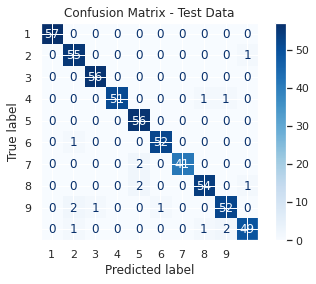

In [63]:
# for the Logistic Regression model

cm.cm_clf_svm(x_test = x_test, y_test=y_test, clf = lr_model);

In [64]:
clf_test.svm_test_data(lr_model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       0.93      0.98      0.96        56
           2       0.98      1.00      0.99        56
           3       1.00      0.96      0.98        53
           4       0.93      1.00      0.97        56
           5       0.98      0.98      0.98        53
           6       1.00      0.95      0.98        43
           7       0.96      0.95      0.96        57
           8       0.95      0.93      0.94        56
           9       0.96      0.92      0.94        53

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540

accTest =  0.9685185185185186


<Figure size 936x432 with 0 Axes>

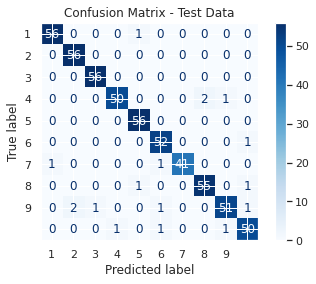

In [65]:
# Now for the Random Forest model
cm.cm_clf_svm(x_test = x_test, y_test=y_test, clf = rf_model);

In [66]:
clf_test.svm_test_data(rf_model)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        57
           1       0.97      1.00      0.98        56
           2       0.98      1.00      0.99        56
           3       0.98      0.94      0.96        53
           4       0.97      1.00      0.98        56
           5       0.95      0.98      0.96        53
           6       1.00      0.95      0.98        43
           7       0.96      0.96      0.96        57
           8       0.96      0.91      0.94        56
           9       0.94      0.94      0.94        53

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540

accTest =  0.9685185185185186


# Conclusions

As presented by the development of this notebook, the SVM models used had better accuracy results (0.985) compared to the Logistic Regression and Radom Forest models.

When we analyse different models of machine learning, it is important to compare the train and validation score, such as accuracy or f1, as we have done in this notebook. Finally, it is important to provide the fine tunning in the models, it can be done using a search function in the possibles hyperparameters of the models. 

I hope you have learned a little more about the SVM algorithm and its importance for the development of predictive models in this notebook. See you!
